In [43]:
from oceanwave_forecast import data_manager
from oceanwave_forecast import data_pipeline

import os
import importlib
importlib.reload(data_manager)
importlib.reload(data_pipeline)

import hvplot.pandas  # registers the .hvplot accessor
import holoviews as hv
hv.extension('bokeh')


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sktime.split import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import ARIMA

from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.compose import ForecastingPipeline, MultiplexForecaster

from sktime.benchmarking.forecasting import ForecastingBenchmark
from sktime.datasets import load_airline
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.split import SlidingWindowSplitter
from sktime.utils.plotting import plot_windows



from sktime.forecasting.compose import TransformedTargetForecaster

from sktime.transformations.series.impute import Imputer
from sktime.forecasting.arima import AutoARIMA
from sklearn.pipeline import make_pipeline, make_union
from skrub import SelectCols

In [44]:

# Define the paths to the three .txt files
folder1_txt = 'D:\\CML\\Term 8\\ML projects\\forecasting_workspace\\oceanwave_forecast\\data\\raw\\Standard meteorological data 2024\\46088h2024.txt'
data_ocean_raw = data_manager.extract_raw_data(folder1_txt)
data_ocean_raw.info()

D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\oceanwave_forecast\data_manager.py:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  # 3) Build a single datetime column and set as index


DataFrame shape: (52650, 13)

Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52650 entries, 2024-01-01 00:00:00 to 2024-12-31 23:50:00
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WDIR    52650 non-null  float64
 1   WSPD    52650 non-null  float64
 2   GST     52650 non-null  float64
 3   WVHT    52650 non-null  float64
 4   DPD     52650 non-null  float64
 5   APD     52650 non-null  float64
 6   MWD     52650 non-null  float64
 7   PRES    52650 non-null  float64
 8   ATMP    52650 non-null  float64
 9   WTMP    52650 non-null  float64
 10  DEWP    52650 non-null  float64
 11  VIS     52650 non-null  float64
 12  TIDE    52650 non-null  float64
dtypes: float64(13)
memory usage: 5.6 MB

Descriptive statistics:
               WDIR          WSPD           GST          WVHT           DPD  \
count  52650.000000  52650.000000  52650.000000  52650.000000  52650.000000   
mean     194.421026      4.962283      6.

In [45]:
processed_data = data_pipeline.preprocess_ocean_data(data_ocean_raw)
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2024-01-01 00:00:00 to 2024-12-31 23:00:00
Freq: h
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   WSPD      8776 non-null   float64
 1   GST       8776 non-null   float64
 2   WVHT      8773 non-null   float64
 3   APD       8773 non-null   float64
 4   PRES      8776 non-null   float64
 5   ATMP      8776 non-null   float64
 6   WTMP      8776 non-null   float64
 7   DEWP      8776 non-null   float64
 8   WDIR_sin  8772 non-null   float64
 9   WDIR_cos  8772 non-null   float64
 10  MWD_sin   5425 non-null   float64
 11  MWD_cos   5425 non-null   float64
dtypes: float64(12)
memory usage: 892.1 KB


D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\oceanwave_forecast\data_pipeline.py:120: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.


In [7]:
# Calculate the number of NaN values and their percentage for each column
nan_summary = processed_data.isnull().sum().to_frame(name='NaN Count')
nan_summary['Percentage (%)'] = (nan_summary['NaN Count'] / len(processed_data)) * 100

# Display the summary
print(nan_summary)



          NaN Count  Percentage (%)
WSPD              8        0.091075
GST               8        0.091075
WVHT             11        0.125228
APD              11        0.125228
PRES              8        0.091075
ATMP              8        0.091075
WTMP              8        0.091075
DEWP              8        0.091075
WDIR_sin         12        0.136612
WDIR_cos         12        0.136612
MWD_sin        3359       38.239982
MWD_cos        3359       38.239982


In [11]:
processed_data_Y = processed_data[['WVHT', 'APD']].copy()
processed_data_X = processed_data.drop(columns=['WVHT', 'APD'])

one_day = 24
one_week = one_day * 7
horizon_steps = one_day*3 # 3 days prediction horizon
training_window = one_week*3  # 3 weeks of training data
fh = ForecastingHorizon(list(range(1, horizon_steps + 1)), is_relative=True)

y_train, y_test, X_train, X_test = temporal_train_test_split(y=processed_data_Y, X=processed_data_X, test_size=horizon_steps)



# cv = SlidingWindowSplitter(fh=fh, window_length=training_window, step_length = one_week)
# print("Total number of evaluations",(cv.get_n_splits(y_train_imputed_df)))
# plot_windows(cv=cv, y=y_train_imputed_df[:one_week*10]) # Plotting for the first 6 weeks of data


# IMPUTATIONS

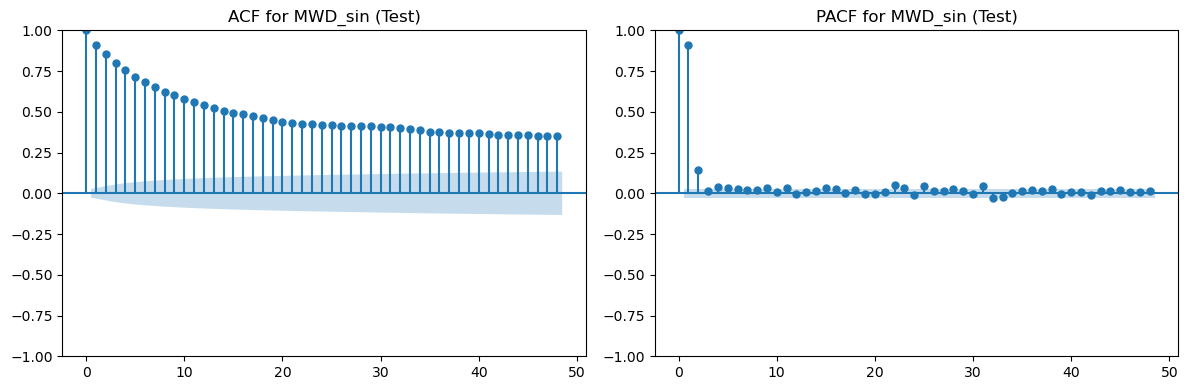

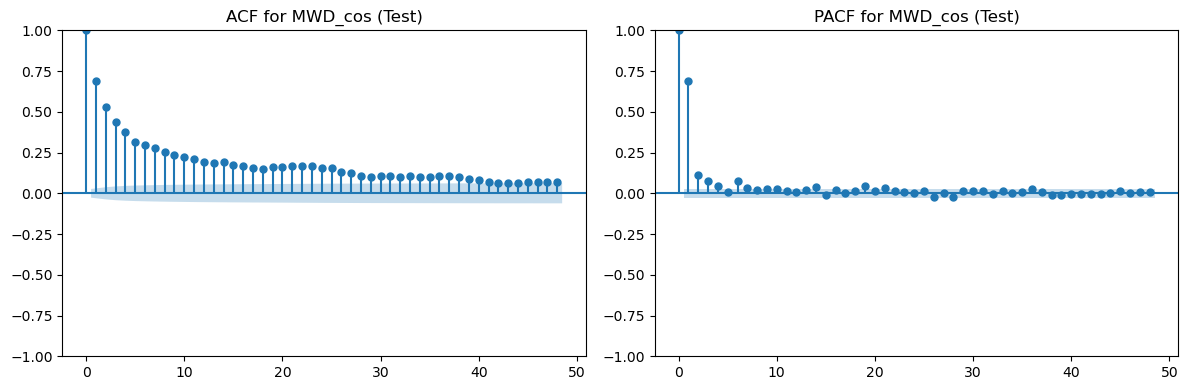

In [12]:
# Note:
# ACF (Autocorrelation Function) Plot:

# Shows a slowly decaying sinusoidal pattern
# Strong positive correlations at early lags that gradually decrease
# Has periodic behavior with alternating positive and negative values
# This pattern suggests non-stationarity and possibly seasonal components

# PACF (Partial Autocorrelation Function) Plot:

# Shows significant spikes at lag 1 and lag 2
# Most other values fall within the significance bounds
# The strong spike at lag 1 suggests an AR(1) component
# The spike at lag 2 reinforces the need for an AR(2) component
        
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for col in ['MWD_sin', 'MWD_cos']:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        # Plot ACF and PACF for the test set, dropping missing values
        plot_acf(X_train[col].dropna(), ax=axes[0], lags=48)
        axes[0].set_title(f'ACF for {col} (Test)')
        plot_pacf(X_train[col].dropna(), ax=axes[1], lags=48)
        axes[1].set_title(f'PACF for {col} (Test)')
        plt.tight_layout()
        plt.show()


In [13]:
# Define angle columns and other columns
angle_columns = ['MWD_sin', 'MWD_cos']
other_columns = [col for col in X_train.columns if col not in angle_columns]

# Pipeline for regular columns (using ffill)
regular_pipeline = make_pipeline(
    SelectCols(other_columns),
    Imputer(method='ffill')
)

# Pipeline for angle columns (using ARIMA)
arima_forecaster = ARIMA(
    order=(4, 0, 0),            # (p,d,q)
    seasonal_order=(1, 0, 0, 24),  # (P,D,Q,s)
    method="lbfgs",             
    maxiter=50,
    suppress_warnings=True
)

angle_pipeline = make_pipeline(
    SelectCols(angle_columns),
    Imputer(method='forecaster', forecaster=arima_forecaster)
)

# Combine pipelines using make_union
X_imputer = make_union(regular_pipeline, angle_pipeline)

# Apply the imputation pipeline to X_train and X_test
X_train_imputed = X_imputer.fit_transform(X_train)
X_test_imputed = X_imputer.transform(X_test)

# Convert the imputed data back to DataFrame format
X_train_imputed_df = pd.DataFrame(
    X_train_imputed,
    index=X_train.index,
    columns=other_columns + angle_columns
)

X_test_imputed_df = pd.DataFrame(
    X_test_imputed,
    index=X_test.index,
    columns=other_columns + angle_columns
)

# Impute the y data
y_imputer = Imputer(method='ffill')
y_train_imputed_df = y_imputer.fit_transform(y_train)
y_test_imputed_df = y_imputer.transform(y_test)


c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  wa

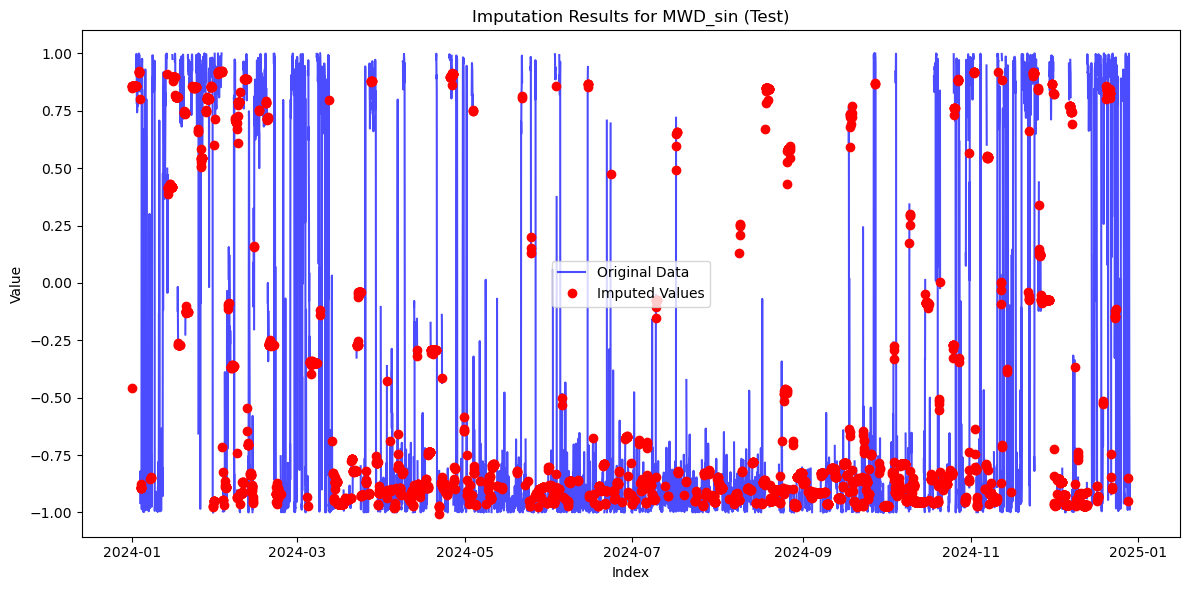

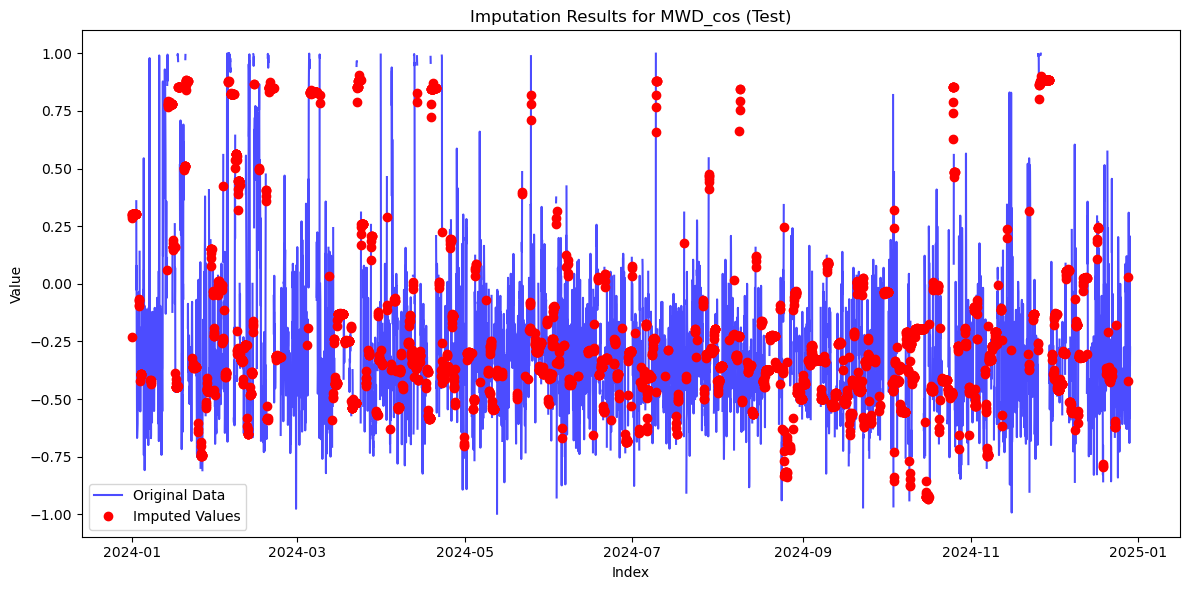

In [14]:
for col in angle_columns:
    if X_train[col].isna().any():
        fig = data_manager.plot_before_after_imputation(X_train[col], X_train_imputed_df[col], f"{col} (Test)")
        plt.show()
    else:
        print(f"No missing values in {col} in test data to impute")

In [ ]:
# Different types of trasnformations
from sktime.datasets import load_longley
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.panel.compose import ColumnTransformer
from sktime.transformations.series.subset import ColumnSelect

from sktime.transformations.compose import ColumnEnsembleTransformer
_, X = load_longley()





# Combine pipelines using make_union
X_imputer = make_union(regular_pipeline, angle_pipeline)

pipe = TransformerPipeline(
        steps = [
            ("detrend", Detrender())
        ]
    )

# Define unique columns and other columns
unique_col = ['GNP']
pipe2 = TransformerPipeline(
    steps=[
        # 1) select just that column (as a 1‑col DataFrame)
        ("select", ColumnSelect(columns=unique_col)),  
        # 2) detrend the resulting univariate series
        ("detrender", Detrender())                          
    ]
)

pipe3  = ColumnEnsembleTransformer(
    transformers=[
        ("detrend_gnp", Detrender(), unique_col),
    ],
    remainder="passthrough",   # everything else is untouched
)



print(X.describe())
Xt = pipe.fit_transform(X)
print(Xt.describe())    
Xt2 = pipe2.fit_transform(X)
print("\n")

print(Xt2.describe()) 
Xt3 = pipe3.fit_transform(X)
print("\n")
print(Xt3.describe())    

          GNPDEFL            GNP        UNEMP        ARMED            POP
count   16.000000      16.000000    16.000000    16.000000      16.000000
mean   101.681250  387698.437500  3193.312500  2606.687500  117424.000000
std     10.791553   99394.937795   934.464247   695.919604    6956.101561
min     83.000000  234289.000000  1870.000000  1456.000000  107608.000000
25%     94.525000  317881.000000  2348.250000  2298.000000  111788.500000
50%    100.600000  381427.000000  3143.500000  2717.500000  116803.500000
75%    111.250000  454085.500000  3842.500000  3060.750000  122304.000000
max    116.900000  554894.000000  4806.000000  3594.000000  130081.000000
            GNPDEFL           GNP         UNEMP         ARMED           POP
count  1.600000e+01  1.600000e+01  1.600000e+01  1.600000e+01  1.600000e+01
mean  -8.615331e-14 -4.874892e-10 -2.557954e-12 -2.529532e-12 -9.367795e-11
std    1.432608e+00  9.652417e+03  6.951768e+02  6.324475e+02  7.638338e+02
min   -2.071471e+00 -1.587697e

# WINDOW SUMMARY

In [ ]:
from sktime.transformations.series.summarize import WindowSummarizer
# Note that the feature gets replaced
y, X = load_longley()

print(X)

pipe = TransformerPipeline(steps=[
    ("max3", WindowSummarizer(
        lag_feature={"max": [[1, 3]]},  
        target_cols=["POP", "GNPDEFL"],
    ))
])

X_transf = pipe.fit_transform(X)
print(X_transf)

        GNPDEFL       GNP   UNEMP   ARMED       POP
Period                                             
1947       83.0  234289.0  2356.0  1590.0  107608.0
1948       88.5  259426.0  2325.0  1456.0  108632.0
1949       88.2  258054.0  3682.0  1616.0  109773.0
1950       89.5  284599.0  3351.0  1650.0  110929.0
1951       96.2  328975.0  2099.0  3099.0  112075.0
1952       98.1  346999.0  1932.0  3594.0  113270.0
1953       99.0  365385.0  1870.0  3547.0  115094.0
1954      100.0  363112.0  3578.0  3350.0  116219.0
1955      101.2  397469.0  2904.0  3048.0  117388.0
1956      104.6  419180.0  2822.0  2857.0  118734.0
1957      108.4  442769.0  2936.0  2798.0  120445.0
1958      110.8  444546.0  4681.0  2637.0  121950.0
1959      112.6  482704.0  3813.0  2552.0  123366.0
1960      114.2  502601.0  3931.0  2514.0  125368.0
1961      115.7  518173.0  4806.0  2572.0  127852.0
1962      116.9  554894.0  4007.0  2827.0  130081.0
        POP_max_1_3  GNPDEFL_max_1_3       GNP   UNEMP   ARMED
P

In [31]:
print(type(X))
print(X)

<class 'pandas.core.frame.DataFrame'>
        GNPDEFL       GNP   UNEMP   ARMED       POP
Period                                             
1947       83.0  234289.0  2356.0  1590.0  107608.0
1948       88.5  259426.0  2325.0  1456.0  108632.0
1949       88.2  258054.0  3682.0  1616.0  109773.0
1950       89.5  284599.0  3351.0  1650.0  110929.0
1951       96.2  328975.0  2099.0  3099.0  112075.0
1952       98.1  346999.0  1932.0  3594.0  113270.0
1953       99.0  365385.0  1870.0  3547.0  115094.0
1954      100.0  363112.0  3578.0  3350.0  116219.0
1955      101.2  397469.0  2904.0  3048.0  117388.0
1956      104.6  419180.0  2822.0  2857.0  118734.0
1957      108.4  442769.0  2936.0  2798.0  120445.0
1958      110.8  444546.0  4681.0  2637.0  121950.0
1959      112.6  482704.0  3813.0  2552.0  123366.0
1960      114.2  502601.0  3931.0  2514.0  125368.0
1961      115.7  518173.0  4806.0  2572.0  127852.0
1962      116.9  554894.0  4007.0  2827.0  130081.0


TransformerPipeline(steps=[('a',
                            WindowSummarizer(lag_feature={'max': [1, 3]},
                                             target_cols=['POP', 'GNPDEFL']))])


# HYPERPARAMETER TUNING

In [41]:
# Chceking the grid formation
from sktime.datasets import load_macroeconomic
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.split import temporal_train_test_split
from sktime.transformations.compose import OptionalPassthrough
from sktime.forecasting.compose import Permute

from sklearn.preprocessing import MinMaxScaler, PowerTransformer, RobustScaler

from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.adapt import TabularToSeriesAdaptor

data = load_macroeconomic()
y = data["unemp"]
X = data.drop(columns=["unemp"])

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=40)
fh = ForecastingHorizon(np.arange(1, 41), is_relative=True)

pipe_y = TransformedTargetForecaster(
    steps=[
        ("detrender_y", OptionalPassthrough(Detrender())),
        ("deseasonalizer_y", OptionalPassthrough(Deseasonalizer())),
        ("scaler_y", OptionalPassthrough(TabularToSeriesAdaptor(RobustScaler()))),
        ("forecaster_y", AutoARIMA(sp=4)),
    ]
)
permuted_y = Permute(pipe_y, permutation=None)

pipe_X = TransformedTargetForecaster(
    steps=[
        ("detrender", OptionalPassthrough(Detrender())),
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(RobustScaler()))),
        ("forecaster", permuted_y),
    ]
)
permuted_X = Permute(pipe_X, permutation=None)


In [42]:
permuted_X.get_params()

{'estimator': TransformedTargetForecaster(steps=[('detrender',
                                     OptionalPassthrough(transformer=Detrender())),
                                    ('deseasonalizer',
                                     OptionalPassthrough(transformer=Deseasonalizer())),
                                    ('scaler',
                                     OptionalPassthrough(transformer=TabularToSeriesAdaptor(transformer=RobustScaler()))),
                                    ('forecaster',
                                     Permute(estimator=TransformedTargetForecaster(steps=[('detrender_y',
                                                                                           OptionalPassthrough(transformer=Detrender())),
                                                                                          ('deseasonalizer_y',
                                                                                           OptionalPassthrough(transformer=Deseasonal

In [40]:
param_grid={
        "estimator__forecaster__permutation": [
            ["detrender", "deseasonalizer", "scaler", "forecaster"],
            ["scaler", "detrender", "deseasonalizer", "forecaster"],
        ],
        "permutation": [
            ["detrender", "deseasonalizer", "scaler", "forecaster"],
            ["scaler", "detrender", "deseasonalizer", "forecaster"],
        ],
        "estimator__forecaster__estimator__scaler__passthrough": [True, False],
        "estimator__scaler__passthrough": [True, False],
    }